# NYC Yellow Taxi Travel Time Prediction

In [1]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pygeohash as pgh
import datetime
import warnings
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import KMeans
from sklearn.model_selection import GridSearchCV 
from sklearn.externals import joblib
from sklearn.metrics import mean_squared_error,mean_squared_log_error , r2_score
from google.cloud import bigquery
from sklearn.ensemble import GradientBoostingRegressor
from math import radians, cos, sin, asin, sqrt,acos

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="4990-fcffed95431b.json"
%matplotlib inline

def rain_level(prcp):
    if prcp==0.0:
        return 'No'
    elif (prcp>0.0) & (prcp<0.098):
        return 'Light'
    elif (prcp>=0.098) & (prcp<0.39):
        return 'Moderate'
    else:
        return 'Heavy'

def get_grid_cv(X_train,y_train,model,param_grid,fold,score,core):
    grid_search = GridSearchCV(model, param_grid, cv=fold,
    scoring=score,n_jobs = core,verbose =10) 
    grid_search.fit(X_train,y_train)
    return grid_search

def get_measure(X_train,y_train,X_test,y_test,model):
    y_pred =model.predict(X_test)
    y_pred_train =model.predict(X_train)   
    ## Test score
    RMSE_test =np.sqrt(mean_squared_error(y_test,y_pred))
    RMSLE_test=np.sqrt(mean_squared_log_error(y_test,y_pred))
    R_score_test = r2_score(y_test,y_pred) 
    ## Train score
    RMSE_train =np.sqrt(mean_squared_error(y_train,y_pred_train))
    RMSLE_train=np.sqrt(mean_squared_log_error(y_train,y_pred_train))
    R_score_train = r2_score(y_train,y_pred_train)
    ### Create metric
    Test = [RMSE_test,RMSLE_test,R_score_test]
    Train =  [RMSE_train,RMSLE_train,R_score_train]
    metric = pd.DataFrame({'Test': Test, 'Train' : Train},index = ['RMSE','RMSLE','R_score']) 
    return metric

def show_cv_results(grid): 
    c = grid.cv_results_
    for mean_score, params in zip(c["mean_test_score"], c["params"]): 
        print(np.sqrt(-mean_score), params)
     
    
def show_grid_cv(grid,para,para_name):
    RMSE_train = np.sqrt(-grid.cv_results_['mean_train_score'])
    RMSE_test = np.sqrt(-grid.cv_results_['mean_test_score'])
    if para_name:
        fig=plt.figure()
        ax = fig.add_axes([0,0,1,1])
        ax.plot(para,RMSE_train,label='Train loss')
        ax.plot(para,RMSE_test,label = 'Validation loss')
        ax.legend(loc=0)
        plt.title('Root mean square error over {}'.format(para_name))
        plt.xlabel(para_name)
        plt.ylabel('rmse')
        plt.show
    else:
        fig=plt.figure()
        ax = fig.add_axes([0,0,1,1])
        ax.plot(RMSE_train,label='Train loss')
        ax.plot(RMSE_test,label = 'Validation loss')
        ax.legend(loc=0)
        plt.title('Root mean square error')
        plt.xlabel('parameters set')
        plt.ylabel('rmse')
        plt.show
        
def show_feature_importance(feature,model):
    feature_importance = model.feature_importances_
    feat = pd.DataFrame(feature_importance)
    feat_name = pd.DataFrame(feature)
    feat_df = pd.concat([feat_name,feat],axis=1)
    feat_df.columns = ["feature","feature_score"]
    feat_df =feat_df.sort_values(by = "feature_score")
    feat_df=feat_df.reset_index(drop=True)
    feat_df[-15:].plot.barh(x='feature',y = 'feature_score',align='center',color = '#1f77b4')
    
    
def RADIANS(x):
    return acos(-1)*x / 180
def RADIANS_TO_KM(x):
    return 111.045 * 180 * x / acos(-1)
def HAVERSINE(lat1,long1,lat2,long2):    
    distance =  RADIANS_TO_KM(
    acos(round(cos(RADIANS(lat1)) * cos(RADIANS(lat2)) *
         cos(RADIANS(long1) - RADIANS(long2)) +
         sin(RADIANS(lat1)) * sin(RADIANS(lat2)),15)))
    return distance


## I.Data Processing

### Wrote SQL pipeline to extract data from BigQuery

In [39]:
start = time.time()
client = bigquery.Client()

query = (
   """
  CREATE TEMP FUNCTION RADIANS(x FLOAT64) AS (
  ACOS(-1) * x / 180
);
CREATE TEMP FUNCTION RADIANS_TO_KM(x FLOAT64) AS (
  111.045 * 180 * x / ACOS(-1)
);
CREATE TEMP FUNCTION HAVERSINE(lat1 FLOAT64, long1 FLOAT64,
                               lat2 FLOAT64, long2 FLOAT64) AS (
  RADIANS_TO_KM(
    ACOS(ROUND(COS(RADIANS(lat1)) * COS(RADIANS(lat2)) *
         COS(RADIANS(long1) - RADIANS(long2)) +
         SIN(RADIANS(lat1)) * SIN(RADIANS(lat2)),15)))
);


select t1.pickup_datetime,EXTRACT(hour from t1.pickup_datetime) as Hour,t1.trip_distance,t1.passenger_count,TIMESTAMP_DIFF( TIMESTAMP(t1.dropoff_datetime),TIMESTAMP (t1.pickup_datetime), SECOND) as travel_time,t1.fare_amount,HAVERSINE(t1.dropoff_latitude,t1.dropoff_longitude, t1.pickup_latitude,t1.pickup_longitude) AS distance_in_km,t1.pickup_longitude, t1.pickup_latitude, t1.dropoff_longitude, t1.dropoff_latitude,if(EXTRACT(dayofweek from pickup_datetime)=6 or EXTRACT(dayofweek from pickup_datetime)=7, 0,1) as week_index,weather.*

from 
(select  pickup_datetime,passenger_count, trip_distance,dropoff_datetime,pickup_longitude, pickup_latitude, dropoff_longitude, dropoff_latitude, 
row_number()over(partition by EXTRACT(date from pickup_datetime),EXTRACT(hour from pickup_datetime)
                   order by  EXTRACT(date from pickup_datetime),EXTRACT(hour from pickup_datetime)) as row_num,fare_amount
from `bigquery-public-data.new_york_taxi_trips.tlc_yellow_trips_2016`) as t1
join
    (
     select concat(year,'-',mo,'-',da) as date_of_year2,year,mo,da,temp,visib,wdsp,prcp,fog,rain_drizzle,snow_ice_pellets
     from `bigquery-public-data.noaa_gsod.gsod2016` where stn='725053'
    ) as weather
    on TIMESTAMP( EXTRACT (DATE from t1.pickup_datetime)) = TIMESTAMP(weather.date_of_year2)

where row_num <=300 and t1.pickup_latitude is not null and t1.pickup_longitude is not null and t1.dropoff_longitude is not null and HAVERSINE(t1.dropoff_latitude,t1.dropoff_longitude, t1.pickup_latitude,t1.pickup_longitude)>0.1
   """
)
df=pd.io.gbq.read_gbq(query,dialect='standard')
sql_time= time.time()-start
print(sql_time)

399.299320936203


In [ ]:
df.to_csv("one_million.csv",index = False)

### Handle Missing values of weather data

In [3]:
df.isnull().sum()

pickup_datetime      0
Hour                 0
trip_distance        0
passenger_count      0
travel_time          0
fare_amount          0
distance_in_km       0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
week_index           0
date_of_year2        0
year                 0
mo                   0
da                   0
temp                 0
visib                0
wdsp                 0
prcp                 0
fog                  0
rain_drizzle         0
snow_ice_pellets     0
dtype: int64

### From the description of weather data, the variable prcp,visib,wdsp contain missing values as 999.99 and temp contains missing value as 9999.99

In [4]:
df.wdsp = df.wdsp.astype('float')
df[['temp','prcp','visib','wdsp']].describe()

,temp,prcp,visib,wdsp
count,1.274188e+06,1.274188e+06,1.274188e+06,1.274188e+06
mean,5.125035e+01,9.678631e-02,3.093801e+01,3.255670e+01
std,1.555277e+01,2.512442e-01,1.455514e+02,1.629413e+02
min,6.900000e+00,0.000000e+00,1.700000e+00,1.200000e+00
25%,3.910000e+01,0.000000e+00,8.700000e+00,3.700000e+00
50%,5.140000e+01,0.000000e+00,9.800000e+00,4.900000e+00
75%,6.340000e+01,5.000000e-02,1.000000e+01,6.400000e+00
max,7.960000e+01,1.820000e+00,9.999000e+02,9.999000e+02


### From the table, it shows there are 999.99 values in the visib(visibility) and wdsp(wind speed) variable. We replace them with missing value first.

In [5]:
df['visib'] = df['visib'].replace(999.9, np.nan)
df['wdsp'] = df['wdsp'].replace(999.9, np.nan)

In [6]:
df.isnull().sum()

pickup_datetime          0
Hour                     0
trip_distance            0
passenger_count          0
travel_time              0
fare_amount              0
distance_in_km           0
pickup_longitude         0
pickup_latitude          0
dropoff_longitude        0
dropoff_latitude         0
week_index               0
date_of_year2            0
year                     0
mo                       0
da                       0
temp                     0
visib                28114
wdsp                 35149
prcp                     0
fog                      0
rain_drizzle             0
snow_ice_pellets         0
dtype: int64

### The above shows that visibility has over 28k missing values and wind speed variable has over 35k missing values. We refill visib and wdsp using forward method which propagates last valid observation forward to next valid and refill prcp with 0

In [7]:
df['visib'] = df['visib'].fillna(method='ffill')
df['wdsp'] = df['wdsp'].fillna(method='ffill')              

### Remove outliers of trip records

In [8]:
shape_before = df.shape
shape_before

(1274188, 23)

In [9]:
df[['trip_distance', 'passenger_count','travel_time', 'fare_amount', 'distance_in_km']].describe()

,trip_distance,passenger_count,travel_time,fare_amount,distance_in_km
count,1.274188e+06,1.274188e+06,1.274188e+06,1.274188e+06,1.274188e+06
mean,4.079502e+00,1.657586e+00,1.013648e+03,1.516606e+01,4.512260e+01
std,3.082005e+02,1.313311e+00,1.054046e+04,5.569563e+02,5.934157e+02
min,0.000000e+00,0.000000e+00,-7.411217e+06,-2.750000e+02,1.000813e-01
25%,1.100000e+00,1.000000e+00,4.080000e+02,7.000000e+00,1.375161e+00
50%,2.000000e+00,1.000000e+00,7.060000e+02,1.000000e+01,2.469194e+00
75%,4.400000e+00,2.000000e+00,1.172000e+03,1.800000e+01,5.326640e+00
max,3.180000e+05,9.000000e+00,6.445984e+06,6.285447e+05,1.255801e+04


### From the table above, we see there exists trips with negative travel time, zero trip_distance, and zero passenger trips

###  Check there are values less than 2.5 in the fare_amount variable since the starting price for a trip of the yellow cab is 2.5.

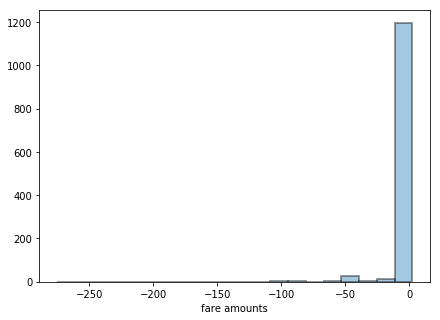

In [10]:
plt.figure(figsize = (7,5))
sns.distplot(df[df['fare_amount']<2.5]['fare_amount'],kde=False,bins=20,hist_kws=dict(edgecolor="k", linewidth=2),axlabel='fare amounts')

### Remove trips with fare amount less than 2.5 , zero passenger counts, and zero trip distance. Besides, we remove travel time larger than two hours and less than one minute.

In [11]:
df = df[(df.fare_amount>=2.5) & (df.passenger_count>0)]
df = df[(df.travel_time>=60) &(df.travel_time<7200)]
df = df[df.trip_distance!=0]

### We restrict the longitude and latitude within the New York City

In [12]:
lon = [-74.03, -73.77]
lat = [40.63, 40.85]
df = df[(df.pickup_longitude> lon[0]) & (df.pickup_longitude < lon[1])]
df = df[(df.dropoff_longitude> lon[0]) & (df.dropoff_longitude < lon[1])]
df = df[(df.pickup_latitude> lat[0]) & (df.pickup_latitude < lat[1])]
df = df[(df.dropoff_latitude> lat[0]) & (df.dropoff_latitude < lat[1])]

In [13]:
df.shape

(1229842, 23)

In [14]:
num_removed = shape_before[0]- df.shape[0]
num_removed

44346

### After the data processing part, we removed over 43k outliers.

In [15]:
df = df.reset_index(drop=True)
df.to_csv('cleanned.csv',index=False)

## II.Feature Engineering

In [26]:
#df = pd.read_csv('cleanned.csv')

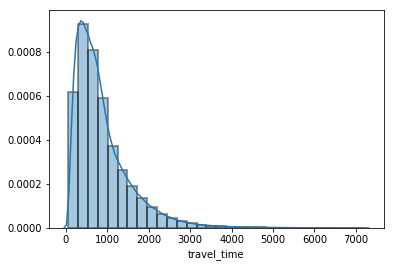

In [29]:
sns.distplot(df['travel_time'], axlabel = 'travel_time', bins = 30,hist_kws=dict(edgecolor="k", linewidth=2))

### The plot shows that the distribution of travel time is right-skewed due to the long travel time of some trips. So we apply log transformation to it.

### Log transformation of travel time

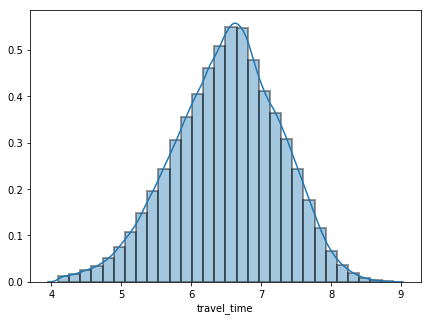

In [30]:
df['travel_time'] = np.log(df['travel_time'])
plt.figure(figsize = (7,5))
sns.distplot(df['travel_time'], axlabel = 'travel_time', bins = 30,hist_kws=dict(edgecolor="k", linewidth=2))

### Now the distribution of travel time is normal.

### Convert categorical features into one hot encoded dummy variables.

In [31]:
start = time.time()
#Construct rain features
df['rain_level'] = df.apply(lambda x: rain_level(x['prcp']),axis=1)
df = pd.get_dummies(df,columns=['rain_level'],prefix=['rain'],drop_first=True)
end = time.time()
print('The rain features cost {} seconds'.format(round(end - start,2)))

The rain features cost 10.6 seconds


### In New York City, we consider the rush hour is from 7:00 to 11:00 and 15:00 to 20:00, We assign 1 if pickup time in rush hours  0 otherwise.

In [32]:
start = time.time()
#Construct rush hour feature
rush_hour = [7,8,9,10,15,16,17,18,19]
df['rush_hour_ind']=df['Hour'].apply(lambda x: 1 if x in rush_hour else 0)
end = time.time()
print('The rush hour feature cost {} seconds'.format(round(end - start,2)))

The rush hour feature cost 0.38 seconds


###  Adding Geohash feature based on latitude and longtitude variables

#### We use the average historical travel time, trip distance, and fare amount in terms of the same pickup area and drop-off area, with geohash precision = 6. For example, if someone travels from abcdef (geohash code) to abcdeg (geohash code) at 15:00 on May 15th, we calculate the average historical travel time, trip distance, and fare amount for trips that traveled from abcdef to abcdeg. 

In [33]:
start = time.time()
# We obtain geohash with precision = 6 for all data
df['pickup_geohash'] = df.apply(lambda x: pgh.encode(x['pickup_latitude'], x['pickup_longitude'],precision=6), axis=1)
df['dropoff_geohash'] = df.apply(lambda x: pgh.encode(x['dropoff_latitude'], x['dropoff_longitude'],precision=6), axis=1)
df['gh'] = df['pickup_geohash'] + df['dropoff_geohash']

# We calculate average historical ‘travel time’ in terms of the same pickup area and drop off area, with geohash precision = 6.
df_transform = df.sort_values('pickup_datetime').groupby(['gh'])['travel_time'].transform('shift')
df_transform = pd.DataFrame(df_transform)
df_transform.columns = ['travel_time_shift']
df = pd.concat([df,df_transform],axis=1)
result = df.sort_values('pickup_datetime').groupby(['gh'])['travel_time_shift'].expanding().mean()
result = pd.DataFrame(result)
result = result.reset_index(level=0,drop=True)
result.columns = ['avg_travel_time']
df = pd.concat([df,result],axis=1)

# We calculate average historical 'trip distance' in terms of the same pickup area and drop off area, with geohash precision = 6.
df_transform = df.sort_values('pickup_datetime').groupby(['gh'])['trip_distance'].transform('shift')
df_transform = pd.DataFrame(df_transform)
df_transform.columns = ['travel_dist_shift']
df = pd.concat([df,df_transform],axis=1)
result = df.sort_values('pickup_datetime').groupby(['gh'])['travel_dist_shift'].expanding().mean()
result = pd.DataFrame(result)
result = result.reset_index(level=0,drop=True)
result.columns = ['avg_trip_dist']
df = pd.concat([df,result],axis=1)

# We calculate average historical 'fare amount' in terms of the same pickup area and drop off area, with geohash precision = 6.
df_transform = df.sort_values('pickup_datetime').groupby(['gh'])['fare_amount'].transform('shift')
df_transform = pd.DataFrame(df_transform)
df_transform.columns = ['fare_amount_shift']
df = pd.concat([df,df_transform],axis=1)
result = df.sort_values('pickup_datetime').groupby(['gh'])['fare_amount_shift'].expanding().mean()
result = pd.DataFrame(result)
result = result.reset_index(level=0,drop=True)
result.columns = ['avg_fare_amount']
df = pd.concat([df,result],axis=1)

end = time.time()
print('The geohash features cost {} mins'.format(round((end - start)/60,2)))

The geohash features cost 1.63 mins


In [34]:
df.columns

Index(['pickup_datetime', 'Hour', 'trip_distance', 'passenger_count',
       'travel_time', 'fare_amount', 'distance_in_km', 'pickup_longitude',
       'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude',
       'week_index', 'date_of_year2', 'year', 'mo', 'da', 'temp', 'visib',
       'wdsp', 'prcp', 'fog', 'rain_drizzle', 'snow_ice_pellets', 'rain_Light',
       'rain_Moderate', 'rain_No', 'rush_hour_ind', 'pickup_geohash',
       'dropoff_geohash', 'gh', 'travel_time_shift', 'avg_travel_time',
       'travel_dist_shift', 'avg_trip_dist', 'fare_amount_shift',
       'avg_fare_amount'],
      dtype='object')

In [37]:
df = df.drop(['passenger_count','trip_distance','year','mo','da','prcp','pickup_geohash','travel_time_shift','dropoff_geohash','travel_dist_shift','fare_amount','fare_amount_shift','date_of_year2'],axis=1)
df.isnull().sum()

pickup_datetime          0
Hour                     0
travel_time              0
distance_in_km           0
pickup_longitude         0
pickup_latitude          0
dropoff_longitude        0
dropoff_latitude         0
week_index               0
temp                     0
visib                    0
wdsp                     0
fog                      0
rain_drizzle             0
snow_ice_pellets         0
rain_Light               0
rain_Moderate            0
rain_No                  0
rush_hour_ind            0
gh                       0
avg_travel_time      51666
avg_trip_dist        51666
avg_fare_amount      51666
dtype: int64

### Since some trips don't have historical records, the geohash features will be filled with 0

In [38]:
df = df.fillna(0)

### Adding K-means Clustering features based on pickup and dropoff locations

In [39]:
df_kmean = df[['pickup_longitude','pickup_latitude','dropoff_latitude','dropoff_longitude']]
df_kmean.head()

,pickup_longitude,pickup_latitude,dropoff_latitude,dropoff_longitude
0,-73.980690,40.733959,40.745708,-73.975929
1,-73.980324,40.759773,40.769363,-73.960686
2,-73.989197,40.757729,40.786228,-73.975983
3,-73.965927,40.762650,40.793339,-73.940529
4,-73.981026,40.729553,40.730923,-74.002884


In [40]:
start =time.time()
kmean = KMeans(n_clusters=20,random_state=0)
kmean.fit(df_kmean)
df_kmean['label'] = kmean.labels_
end = time.time()
print('The kmeans features cost {} mins'.format(round((end - start)/60,2)))

The kmeans features cost 3.56 mins


### Visuliaze the K-means Clustering features

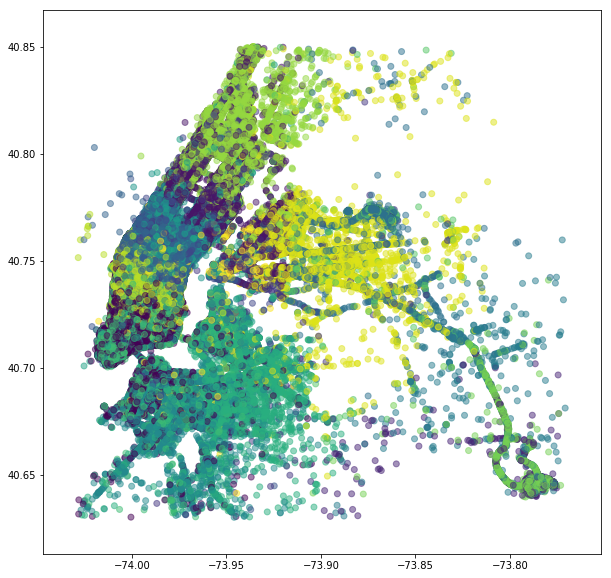

In [41]:
plt.figure(figsize = (10,10))
xs = df_kmean.pickup_longitude
ys = df_kmean.pickup_latitude
labels = df_kmean.label
plt.scatter(xs, ys, c=labels, alpha=0.5)
plt.show()

In [42]:
df['kmeans'] = df_kmean.label

In [43]:
df.head()

,pickup_datetime,Hour,travel_time,distance_in_km,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,week_index,temp,visib,wdsp,fog,rain_drizzle,snow_ice_pellets,rain_Light,rain_Moderate,rain_No,rush_hour_ind,gh,avg_travel_time,avg_trip_dist,avg_fare_amount,kmeans
0,2016-01-15 23:35:17,23,5.916202,1.364800,-73.980690,40.733959,-73.975929,40.745708,0,41.2,9.5,3.8,0,0,0,0,0,1,0,dr5rsxdr5ru9,5.852023,1.008571,6.242857,17
1,2016-01-15 23:02:57,23,6.161207,1.965221,-73.980324,40.759773,-73.960686,40.769363,0,41.2,9.5,3.8,0,0,0,0,0,1,0,dr5rusdr5ruv,5.982553,0.910968,6.612903,10
2,2016-01-15 23:04:07,23,6.371612,3.354170,-73.989197,40.757729,-73.975983,40.786228,0,41.2,9.5,3.8,0,0,0,0,0,1,0,dr5ru7dr72h8,6.448090,2.255405,10.027027,10
3,2016-01-15 23:22:02,23,6.583409,4.021803,-73.965927,40.762650,-73.940529,40.793339,0,41.2,9.5,3.8,0,0,0,0,0,1,0,dr5ruudr72j6,6.240136,2.881818,10.318182,10
4,2016-01-15 23:12:16,23,6.602588,1.845618,-73.981026,40.729553,-74.002884,40.730923,0,41.2,9.5,3.8,0,0,0,0,0,1,0,dr5rswdr5rsn,6.338464,1.316667,7.916667,0


In [44]:
df.to_csv('features.csv',index=False)

In [45]:
df_corr_cat = df[['fog','rain_drizzle','snow_ice_pellets','week_index','rain_Light','rain_Moderate','rain_No','rush_hour_ind','travel_time']]

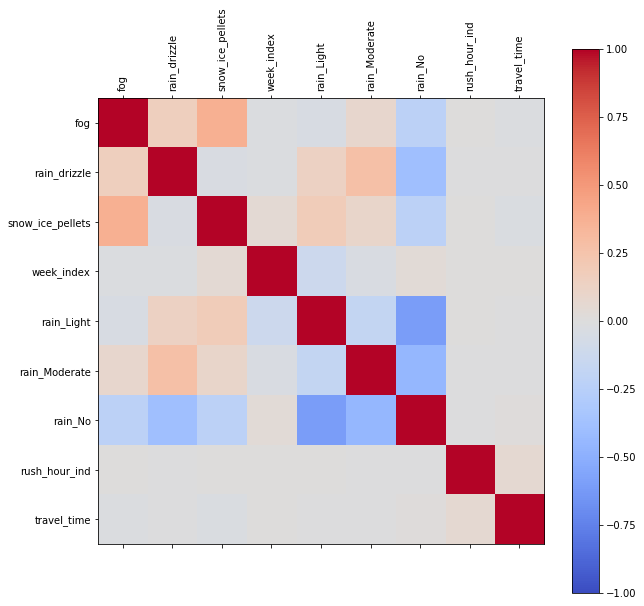

In [46]:
corr = df_corr_cat.corr()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(df_corr_cat.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(df_corr_cat.columns)
ax.set_yticklabels(df_corr_cat.columns)
plt.show()

### From the heatmap above, the correlations bewteen categorical variables are weak.

In [54]:
df[['travel_time','distance_in_km','avg_travel_time','avg_trip_dist','avg_fare_amount']].corr()

,travel_time,distance_in_km,avg_travel_time,avg_trip_dist,avg_fare_amount
travel_time,1.000000,0.684156,0.214261,0.119977,0.621505
distance_in_km,0.684156,1.000000,0.147039,0.178102,0.839664
avg_travel_time,0.214261,0.147039,1.000000,0.100806,0.588189
avg_trip_dist,0.119977,0.178102,0.100806,1.000000,0.198577
avg_fare_amount,0.621505,0.839664,0.588189,0.198577,1.000000


# Model Selection, Comparison and Cross Validation

In [ ]:
#df = pd.read_csv('my_version/features1.csv')

In [48]:
df.columns

Index(['pickup_datetime', 'Hour', 'travel_time', 'distance_in_km',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'week_index', 'temp', 'visib', 'wdsp', 'fog',
       'rain_drizzle', 'snow_ice_pellets', 'rain_Light', 'rain_Moderate',
       'rain_No', 'rush_hour_ind', 'gh', 'avg_travel_time', 'avg_trip_dist',
       'avg_fare_amount', 'kmeans'],
      dtype='object')

In [50]:
X = df.drop(['travel_time','pickup_datetime','gh'],axis =1)
y = df['travel_time']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Random Forest

In [ ]:
num_trees = [10,50,100,150,200]
grid_n_estimators= get_grid_cv(X_train,y_train,RandomForestRegressor(random_state=0,max_features='sqrt'),
                               param_grid = {'n_estimators':num_trees},fold=3,score='neg_mean_squared_error',core =1)
grid_n_estimators.best_params_

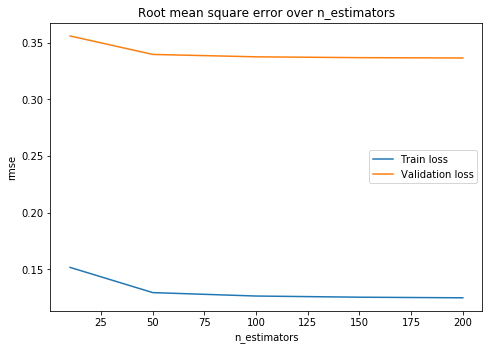

In [63]:
show_grid_cv(grid_n_estimators,num_trees,'n_estimators')

#### From the plot, we see the increase of n_estimators with the decrease of validation error and it doesn't affect overfitting much since the gap between the validation error and the training error doesn't change much. So we pick a large one.

In [ ]:
max_dep = [15,17,19,21]
grid_max_depth= get_grid_cv(X_train,y_train,RandomForestRegressor(random_state=0,max_features='sqrt',n_estimators = 300),
                               param_grid = {'max_depth':max_dep},fold=3,score='neg_mean_squared_error',core =1)

In [ ]:
grid_max_depth.best_params_

In [ ]:
show_grid_cv(grid_max_depth,max_dep,'max_depth')

#### The GridSearchCV returns 20 for max_depth when the validation error is the lowest.  From the plot, we  see after max_depth = 20, the test error no longer decreases. However, the training error starts to fall rapidly, which causes overfitting. So we may pick max_depth from 15 to 20.

In [ ]:
grid_rf_depth = grid_max_depth.best_params_['max_depth']
min_split =np.arange(10,200,20)
grid_min_samples_split= get_grid_cv(X_train,y_train,RandomForestRegressor(random_state=0,max_features='sqrt',max_depth=grid_rf_depth),
                               param_grid = {'min_samples_split':min_split},fold=3,score='neg_mean_squared_error',core =-1)

In [ ]:
grid_min_samples_split.best_params_

In [ ]:
show_grid_cv(grid_min_samples_split,min_split,'min_samples_split')

####  From the plot, we see the small number of min_samples_split will cause overfitting since the gap between validation error and training error is large. The increase of min_samples_split will decrease the overfitting issue, we pick a large number for min_samples_split.

In [ ]:
param = {'n_estimators': [200], 
              'max_depth': [16,18,20], 
              'min_samples_split':[30,40,50]
             }
grid_RF= get_grid_cv(X_train,y_train,RandomForestRegressor(random_state=0,max_features='sqrt'),
                            param_grid=param,fold=3,score='neg_mean_squared_error',core =-1)
grid_RF.best_params_

In [89]:
#forest_reg = RandomForestRegressor(max_depth=20,min_samples_split=30,max_features='sqrt',n_estimators=200,n_jobs=-1,random_state=0)
#forest_reg.fit(X_train,y_train)
#y_pred =forest_reg.predict(X_test)
#get_measure(y_test,y_pred)

RMSE: 0.34183678913057686 
RMSLE: 0.04787303913429366 
R2: 0.7972165236862805


In [90]:
#y_pred_train =forest_reg.predict(X_train)
#get_measure(y_train,y_pred_train)

RMSE: 0.30209307122216206 
RMSLE: 0.04226932957320144 
R2: 0.840654666936244


### We increase the min_samples_split to 100 to decrease the overfitting showed above.

In [91]:
forest_reg = RandomForestRegressor(max_depth=20,min_samples_split=100,max_features='sqrt',n_estimators=200,n_jobs=-1,random_state=0)
forest_reg.fit(X_train,y_train)
y_pred =forest_reg.predict(X_test)
get_measure(y_test,y_pred)

RMSE: 0.3467157445307337 
RMSLE: 0.04853938545981364 
R2: 0.7913866534023941


In [92]:
y_pred_train =forest_reg.predict(X_train)
get_measure(y_train,y_pred_train)

RMSE: 0.326578725245902 
RMSLE: 0.045667331796958296 
R2: 0.8137768800839262


### Top 15 features of Random Forest

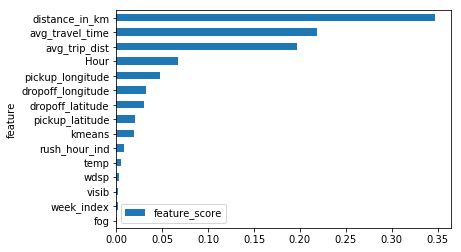

In [106]:
show_feature_importance(feature=X.columns, model=forest_reg)

## Gradient Boosting 

In [ ]:
start =time.time()
GBR= GradientBoostingRegressor(random_state=0,verbose=2)
GBR_n_est = [200,300,400]
param = {'n_estimators': GBR_n_est,  
         'learning_rate':[0.1,0.2],
         'max_depth': [3], 
         'min_samples_split':[100],
         'max_features': ['sqrt'],
         'subsample':[0.8]
        }
GBR_grid1 = get_grid_cv(X_train,y_train,GBR,param_grid=param,fold=3,score='neg_mean_squared_error',core =-1)
total = time.time()-start

In [78]:
print("The cell costs {} seconds ".format(round(total,2)))

The cell costs 765.6 seconds 


In [75]:
GBR_grid1.best_params_

{'learning_rate': 0.2,
 'max_depth': 3,
 'max_features': 'sqrt',
 'min_samples_split': 100,
 'n_estimators': 400,
 'subsample': 0.8}

In [ ]:
param = {'n_estimators':[400],  
         'learning_rate':[0.2],
         'max_depth': [5,7,9], 
         'min_samples_split':[100,150,200,250,300],
         'max_features': ['sqrt'],
         'subsample':[0.8]
        }
GBR_grid2 = get_grid_cv(X_train,y_train,GBR,param_grid=param,fold=3,score='neg_mean_squared_error',core =-1)

In [ ]:
GBR_grid2.best_params_

In [ ]:
GBR_min_split= [100,150,200,250,300,350,400,450,500]
param = {'n_estimators':[400],  
         'learning_rate':[0.2],
         'max_depth': [3], 
         'min_samples_split':GBR_min_split,
         'max_features': ['sqrt'],
         'subsample':[0.8]
        }
GBR_grid2 = get_grid_cv(X_train,y_train,GBR,param_grid=param,fold=3,score='neg_mean_squared_error',core =-1)

In [90]:
GBR_grid2.best_params_

{'learning_rate': 0.2,
 'max_depth': 3,
 'max_features': 'sqrt',
 'min_samples_split': 250,
 'n_estimators': 400,
 'subsample': 0.8}

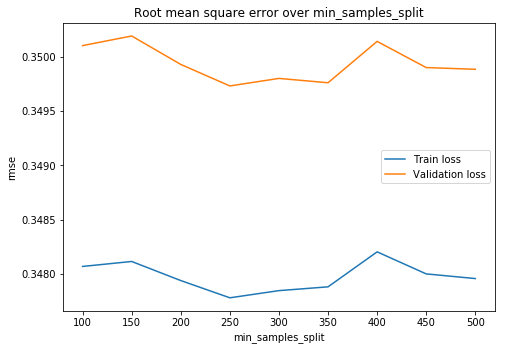

In [91]:
show_grid_cv(GBR_grid2,GBR_min_split,'min_samples_split')

In [ ]:
GBR_max_dep = [5,7,9,11,13]
param = {'n_estimators':[400],  
         'learning_rate':[0.2],
         'max_depth': GBR_max_dep, 
         'min_samples_split':[250],
         'max_features': ['sqrt'],
         'subsample':[0.8]
        }
GBR_grid3 = get_grid_cv(X_train,y_train,GBR,param_grid=param,fold=3,score='neg_mean_squared_error',core =-1)

In [93]:
GBR_grid3.best_params_

{'learning_rate': 0.2,
 'max_depth': 11,
 'max_features': 'sqrt',
 'min_samples_split': 250,
 'n_estimators': 400,
 'subsample': 0.8}

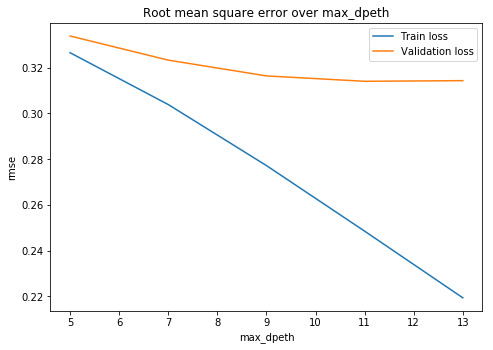

In [94]:
show_grid_cv(GBR_grid3,GBR_max_dep,'max_dpeth')

In [ ]:
GBR_sub =  [0.6,0.7,0.75,0.8,0.85,0.9]
param={'learning_rate': [0.2],
 'max_depth': [11],
 'max_features': ['sqrt'],
 'min_samples_split': [250],
 'n_estimators': [400],
 'subsample': GBR_sub}
GBR_grid4 = get_grid_cv(X_train,y_train,GBR,param_grid=param,fold=3,score='neg_mean_squared_error',core =-1)

In [105]:
GBR_grid4.best_params_

{'learning_rate': 0.2,
 'max_depth': 11,
 'max_features': 'sqrt',
 'min_samples_split': 250,
 'n_estimators': 400,
 'subsample': 0.9}

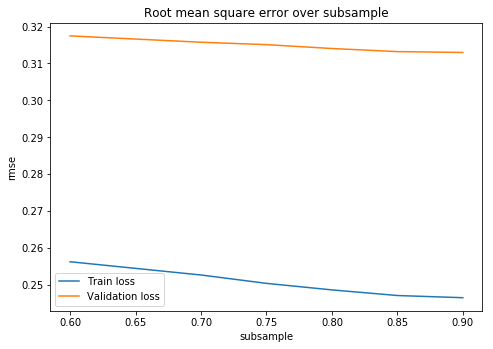

In [109]:
show_grid_cv(GBR_grid4,GBR_sub,'subsample')

In [ ]:
grid_best = {'learning_rate': 0.2,
 'max_depth': 11,
 'max_features': 'sqrt',
 'min_samples_split': 250,
 'n_estimators': 400,
 'subsample': 0.9,
 'verbose':2,
 'random_state': 0 }
boost_reg = GradientBoostingRegressor(**grid_best)
boost_reg.fit(X_train,y_train)

In [113]:
get_measure(X_train,y_train,X_test,y_test,boost_reg)

,Test,Train
RMSE,0.307936,0.253770
RMSLE,0.043358,0.035272
R_score,0.835153,0.887480


In [ ]:
grid_best = {'learning_rate': 0.2,
 'max_depth': 9,
 'max_features': 'sqrt',
 'min_samples_split': 250,
 'n_estimators': 400,
 'subsample': 0.9,
 'verbose':2,
 'random_state': 0 }
boost_reg = GradientBoostingRegressor(**grid_best)
boost_reg.fit(X_train,y_train)

In [115]:
get_measure(X_train,y_train,X_test,y_test,boost_reg)

,Test,Train
RMSE,0.311689,0.281081
RMSLE,0.043870,0.039254
R_score,0.831111,0.861958


In [39]:
###Try some larger number of min_sample_split with depth 11

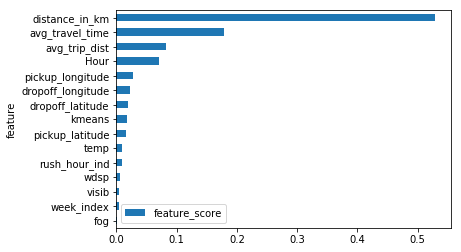

In [56]:
show_feature_importance(feature=X.columns, model=boost_reg)

In [40]:
boost_reg.feature_importances_

array([7.05118889e-02, 5.29326368e-01, 2.76694734e-02, 1.50394588e-02,
       2.20139027e-02, 1.97271194e-02, 3.58479980e-03, 9.60257964e-03,
       4.67575617e-03, 6.49202988e-03, 1.18687686e-03, 6.49730842e-04,
       5.15564836e-04, 4.24104621e-04, 8.51138953e-04, 5.68461007e-04,
       8.59248511e-03, 1.78703450e-01, 8.17266641e-02, 1.81381475e-02])

## Testing

### Construct testing features

In [2]:
df_test = pd.read_csv('APM4990_final_test_data_filtered.csv')

In [3]:
client = bigquery.Client()
query=(
'''
select concat(year,'-',mo,'-',da) as date_of_year2,year,mo,da,temp,visib,wdsp,prcp,fog,rain_drizzle,snow_ice_pellets
from `bigquery-public-data.noaa_gsod.gsod2015` where stn='725053'
''')

weather_2015 = pd.io.gbq.read_gbq(query,dialect='standard')

In [4]:
df_test.insert(loc=0,column = 'datetime', value =pd.to_datetime(df_test['pickup_datetime']))
df_test.insert(loc = 0, column = 'date_of_year2',value=df_test['datetime'].apply(lambda x: x.strftime('%Y-%m-%d')))
df_test = pd.merge(df_test, weather_2015, how='left', on=['date_of_year2'])
df_test['Hour']=df_test.datetime.dt.hour
df_test['week']=df_test.datetime.dt.dayofweek
df_test['week_index']= df_test['week'].apply(lambda x: 0 if x==5 or x==6 else 1 )
df_test = df_test.drop(['date_of_year2','pickup_datetime','passenger_count','year','da','week'],axis=1)
df_test.rename(columns={'datetime':'pickup_datetime'}, inplace=True)

In [6]:
df_test['rain_level'] = df_test.apply(lambda x: rain_level(x['prcp']),axis=1)

In [7]:
df_test = pd.get_dummies(df_test,columns=['rain_level'],prefix=['rain'],drop_first=True)

In [8]:
rush_hour = [7,8,9,10,15,16,17,18,19]
df_test['rush_hour_ind']=df_test['Hour'].apply(lambda x: 1 if x in rush_hour else 0)

In [9]:
# We obtain geohash with precision = 6 for all data
df_test['pickup_geohash'] = df_test.apply(lambda x: pgh.encode(x['pickup_latitude'], x['pickup_longitude'],precision=6), axis=1)
df_test['dropoff_geohash'] = df_test.apply(lambda x: pgh.encode(x['dropoff_latitude'], x['dropoff_longitude'],precision=6), axis=1)
df_test['gh'] = df_test['pickup_geohash'] + df_test['dropoff_geohash']
df_test_match = df_test[['pickup_datetime','gh','Hour']]
df_test_match['data_index'] = 0

In [38]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime']) - datetime.timedelta(days=365)

In [ ]:
df_train_match = df[['pickup_datetime','gh','Hour','avg_travel_time','avg_trip_dist']]
df_train_match['data_index'] = 1
df_train_match.head()

In [ ]:
df_merge = pd.concat([df_test_match,df_train_match], axis=0, ignore_index=True)

In [44]:
df_merge['avg_travel_time'] = df_merge.sort_values('pickup_datetime').groupby(['gh'])['avg_travel_time'].fillna(method='ffill')
df_merge['avg_trip_dist'] = df_merge.sort_values('pickup_datetime').groupby(['gh'])['avg_trip_dist'].fillna(method='ffill')
df_merge['avg_fare_amount'] = df_merge.sort_values('pickup_datetime').groupby(['gh'])['avg_fare_amount'].fillna(method='ffill')

In [46]:
df_merge_test = df_merge[df_merge['data_index'] == 0]

In [47]:
df_test['avg_travel_time'] = df_merge_test['avg_travel_time']
df_test['avg_trip_dist'] = df_merge_test['avg_trip_dist']
df_test['avg_fare_amount'] = df_merge_test['avg_fare_amount']

In [ ]:
df_test.isnull().sum()

In [49]:
df_test = df_test.fillna(0)

In [50]:
df_test_final = df_test.drop(['pickup_datetime','pickup_geohash','dropoff_geohash','gh','prcp','mo'],axis=1)

In [51]:
df_test_final['distance_in_km'] = df_test_final.apply(lambda x: HAVERSINE(x['pickup_latitude'],x['pickup_longitude'],x['dropoff_latitude'],x['dropoff_longitude']),axis=1)

## Prediction

In [ ]:
df_test_final.shape

In [ ]:
df_test_final.columns

In [ ]:
X.columns

In [ ]:
df_final = df[['pickup_latitude', 'pickup_longitude', 'dropoff_latitude',
       'dropoff_longitude', 'temp', 'visib', 'wdsp', 'fog', 'rain_drizzle',
       'snow_ice_pellets', 'Hour', 'week_index', 'rain_Light', 'rain_Moderate',
       'rain_No', 'rush_hour_ind', 'avg_fare_amount', 'avg_hr_fare_amount',
       'avg_hr_travel_time', 'avg_hr_trip_dist', 'avg_travel_time',
       'avg_trip_dist', 'distance_in_km','travel_time']]

In [ ]:
X = df_final.drop(['travel_time'],axis =1)
y = df_final['travel_time']

## Train entire data using Gradient Boosting and make prediction

In [ ]:
grid_best = {'learning_rate': 0.2,
 'max_depth': 7,
 'max_features': 'sqrt',
 'min_samples_split': 200,
 'n_estimators': 500,
 'subsample': 0.8,
 'verbose': 2}
boost_reg = GradientBoostingRegressor(**grid_best)
boost_reg.fit(X_train,y_train)

In [17]:
boost_reg = boost_reg.predict(df_test_final)

In [19]:
travel_pred = pd.DataFrame(data ={'travel_time':final_pred})

travel_pred.head()

In [21]:
travel_pred.shape

(694047, 1)

In [22]:
travel_pred.to_csv('travel_pred.csv',index=False)